In [1]:
import numpy as np 
from itertools import product
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
from plot_param import *

from models.game import *

from plot_param import *



In [2]:
FIRST_YEAR = 2020
"Year of the first occurence of the game."

FINAL_YEAR = 2100
"Year of the last occurence of the game."

STEP = 5
"Number of years between two occurence of the game."

T = int((FINAL_YEAR - FIRST_YEAR) / STEP) 

horizon = FINAL_YEAR

r = [1.15, 1.60, 2, 0.5, 1.25,0.75]
e = [2, -2, -5, -4, -5, 2.5]

In [3]:
N = 2
"Default number of players"

# Espaces d'action des joueurs en GtCO2


ACTION_SETS =  np.array([[[0.0, 11.47],        # China  
                         [0.0, 5.01]]]*2*T)*4       # other 

ACTION_SETS = np.swapaxes(ACTION_SETS,0,1)


r"""Default action set of the players.

References
----------

.. [1] Hannah Ritchie, Max Roser and Pablo Rosado (2020) - "CO₂ and Greenhouse Gas Emissions". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions' [Online Resource]
       https://ourworldindata.org/grapher/annual-co2-emissions-per-country?facet=none&country=CHN~USA~European+Union+%2828%29~IND~RUS~Asia+%28excl.+China+and+India%29

"""

# ACTION_SETS =  np.array([[[0.0, 10.0],        # China  
#                          [0.0, 0.1],         # USA
#                          [0.0, 0.1],         # EU
#                          [0.0, 0.1],         # India
#                          [0.0, 0.1],         # Russia
#                          [0.0, 0.1]]]*T)  
# Coefficient d'impact de la temperature sur le climat 

DELTAS = np.array([1.1847,
                    1.1941])
r"""Default damage multiplier. 

References
----------

.. [1] http://www.fund-model.org/MimiFUND.jl/latest/tables/#Table-RT:-Regional-temperature-conversion-factor-1
"""



# PIB max des joueurs, j'ai pris le PIB 2020                

GDP_MAX = np.array([14.63,
                    19.29])*10


NAMES = ['China', 'USA']


r = [ 0.2, 0.4]
e = [10,-2]

In [4]:
lower_bounds = np.copy(ACTION_SETS[:,:T,:][..., 0])
upper_bounds = np.copy(ACTION_SETS[:,:T,:][..., 1])

In [5]:
from utility.array_to_latex import array_to_latex

X = 2020 + np.arange((horizon-2020)//5 )*5

list_t_piece = np.arange(1,T,2)


list_damage_coef = [np.array([0,0,1]), np.array([0,-2,2]), np.array([0,0.25,0.16])] #, np.array([0,0,2]) ] #np.array([0,-2,2]),  np.array([0,-0.5,1.1])] #, np.array([0,0,1.1450]), np.array([0,0,0,0,1])]
list_alpha = [1,1.5,2] #[1,1.5,2]
list_list_benefit_functions = [
                                [partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)],
                                # BENEFITS_CONCAVE,
                                ]
 #[partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)], BENEFITS_LOG]
list_label_benefit_function = [
                                ('Sigmoid', '-'),
                                # ('Concave', '--'),
                                ]
#, #, ('Logaritmic', 'dotted')]
# list_damage_label = [array_to_latex(coef) for coef in list_damage_coef]
list_damage_function = [
    partial(damage_polynome, coefficients = coef) for coef in list_damage_coef
    ]

list_damage_label = [array_to_latex(coef) for coef in list_damage_coef]

case = 'sigmoid'
list_param = list(product(list_damage_coef, list_alpha, list_list_benefit_functions))
list_label = list(product(list_damage_label, list_alpha, list_label_benefit_function))



In [6]:
def process_sum(list_strategy_profile, game : Game) : 
    data_utilities = []
    data_temp = []
    list_sum_strategy = np.sum(list_strategy_profile, axis=1)
    list_ = list(zip(list_strategy_profile,list_sum_strategy))
    for strategy, sum_ in tqdm(list_, total = len(list_), desc ='Processing'):
        u,temp = game.game_with_strategies_profile(strategy,sum_)
        data_utilities.append(np.sum(u))
        data_temp.append(temp[T-1])
    data_sum = np.sum(list_sum_strategy, axis=1) *5 /1e3  # Player take action of CO2 per years, each step is 5 years so we need to multiply it by 5. We divide by 1e3 for expressing it in 1e3 GtCO2
    return np.array(data_utilities), np.array(data_temp), data_sum

## High damage

In [7]:
alpha = list_alpha[1]
benef = list_list_benefit_functions[0]
damage = list_damage_function[1]
coef_str = array_to_latex(list_damage_coef[1])

list_players = create_players(alpha=alpha, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=benef, damage_function=damage, discount=1)
game = Game(list_players, horizon=horizon)

a_, sum_a_, u_, sum_u_, temp_ = game.receding_BRD_by_piece_return(1)
a_so, sum_a_so, u_so, sum_u_so, temp_so = game.planning_SO_by_piece_return(1)

a_rece, sum_a_rece, u_rece, sum_u_rece, temp_rece = game.receding_BRD_by_piece_return(T)
a_plan, sum_a_plan, u_plan, sum_u_plan, temp_plan = game.planning_BRD_by_piece_return(T)

a_plan_so, sum_a_plan_so, u_plan_so, sum_u_plan_so, temp_plan_so = game.planning_SO_by_piece_return(T)
a_rece_so, sum_a_rece_so, u_rece_so, sum_u_rece_so, temp_rece_so = game.receding_SO_by_piece_return(T)

list_a = [a_, a_so, a_plan, a_plan_so, a_rece, a_rece_so]

u__ = np.sum(u_, axis=1)
u_so_ = np.sum(u_so, axis =1)
u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

list_u =  [u__, u_so_, u_p, u_p_so, u_r, u_r_so]
list_sum_u =  [np.sum(uu) for uu in list_u]
list_sum_a =  [np.sum(aa)*5/1000 for aa in list_a]

list_temp = [temp_, temp_so, temp_plan, temp_plan_so, temp_rece, temp_rece_so]
list_temp_solution_concept = [t_[T-1] for t_ in list_temp]
list_solution_concept = ['NE', 'SO', 'PLAN_NE', 'PLAN_SO', 'RECE_NE', 'RECE_SO']
dict_sum_u = dict(zip(list_solution_concept,list_sum_u))
dict_sum_a = dict(zip(list_solution_concept,list_sum_a))
dict_temp = dict(zip(list_solution_concept,list_temp_solution_concept))

Receding BRD, t_piece = 1:   0%|          | 0/16 [00:00<?, ?it/s]

Receding SO, t_piece = 16: 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]


In [8]:
dict_temp

{'NE': 3.1886205212272403,
 'SO': 2.861281641084475,
 'PLAN_NE': 2.622193841730871,
 'PLAN_SO': 2.482278955701561,
 'RECE_NE': 2.5229329458099694,
 'RECE_SO': 2.2597911213329165}

In [9]:
import numpy as np

def generate_sample_close_to_point(point, epsilon, low, up):

    lower_bound = max(low, point - epsilon)
    upper_bound = min(up, point + epsilon)
    sample = np.random.uniform(lower_bound, upper_bound)
    
    return sample


In [10]:
strats = []
epsilon = [0.5, 2, 5, 10, 15,20]
for idx in range(N):
    samples = []
    for e in epsilon :
        for point in np.linspace(lower_bounds[idx,0], upper_bounds[idx,0], 100):
            sample = [point]
            for t in range(T-1):
                sample.append(generate_sample_close_to_point(point, e, lower_bounds[idx,0], upper_bounds[idx,0]))
            samples.append(sample)
    strats.append(samples)

In [11]:
len(strats[0])

600

In [12]:
x = list(product(*strats))
print(len(x))

360000


In [13]:
data_u_x, data_t_x, data_sum_x = process_sum(x, game)

Processing: 100%|██████████| 360000/360000 [02:45<00:00, 2181.22it/s]


In [14]:
low_temp = game.scm_game.evaluate_trajectory(np.sum(lower_bounds, axis = 0))[-1][-1]
up_temp = game.scm_game.evaluate_trajectory(np.sum(upper_bounds, axis = 0))[-1][-1]

print(low_temp, up_temp)

pareto_ = []
for temp in np.linspace(low_temp, up_temp, 20) :
    pareto_.append(game.planning_social_optimum_with_constraint_temperature(constraint_value=temp))

pareto = []
for p in pareto_:
    pareto.append(process_sum(np.array([p]), game))

pareto = np.array(pareto)

1.2134680568797676 3.1886205212272403


Processing: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [15]:
p = np.argsort(data_u_x)
data_u_x = data_u_x[p]
data_t_x = data_t_x[p]
data_sum_x = data_sum_x[p]
p = np.argsort(data_t_x)
data_u_x = data_u_x[p]
data_t_x = data_t_x[p]
data_sum_x = data_sum_x[p]
p = np.argsort(data_u_x)
data_u_x = data_u_x[p]
data_t_x = data_t_x[p]
data_sum_x = data_sum_x[p]

s = np.linspace(50, 5, num = len(data_u_x))*5

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_46824\3021804382.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p, extend='both')


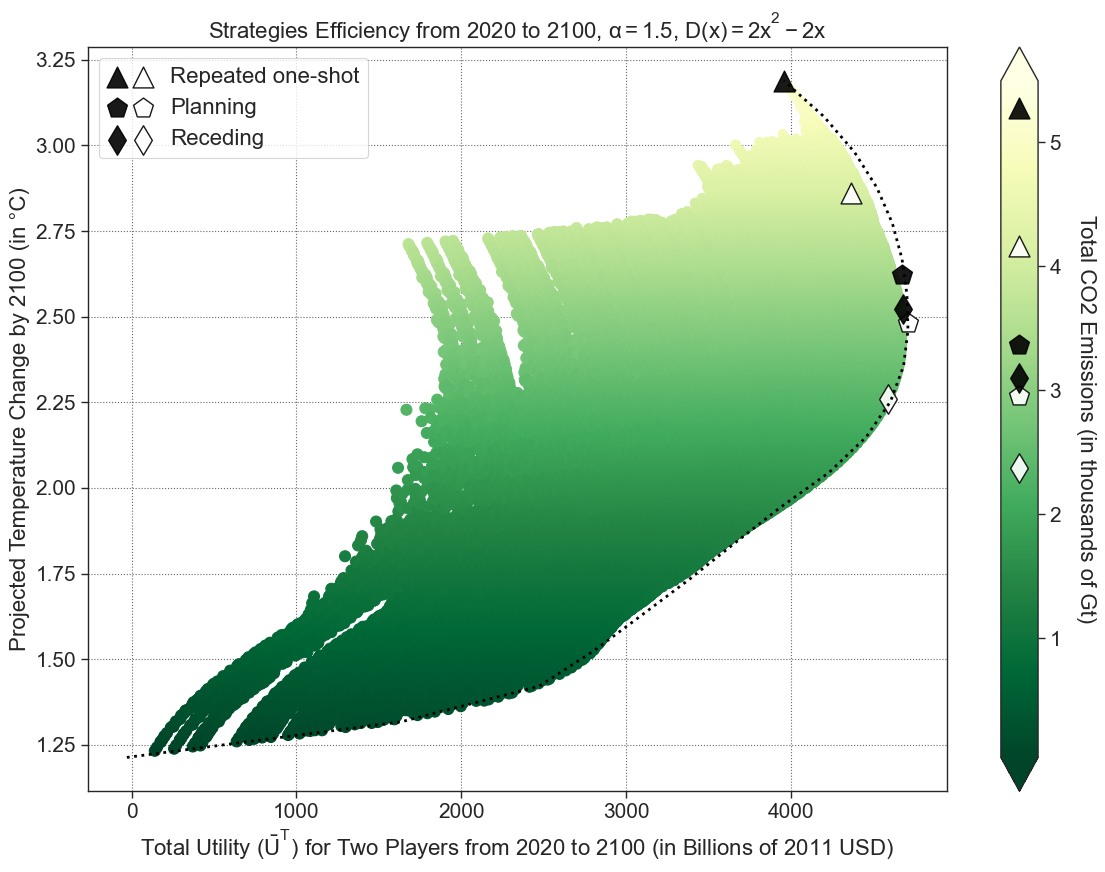

In [16]:
from matplotlib.legend_handler import HandlerTuple

fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
#p = ax.scatter(shuffled_data_u, shuffled_data_t, c=shuffled_data_sum, cmap='coolwarm', marker='.',)
p = ax.scatter(
    data_u_x,
    data_t_x, 
    c=data_sum_x, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x, data_sum_x*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)

ax.plot(pareto[:,0], pareto[:,1], c='black', lw=2 , ls = 'dotted')

p1 = ax.scatter(dict_sum_u['NE'], dict_temp['NE'], **style_scatter, **one_shot_style, **ne_style, label='Repeated one-shot')
p2 = ax.scatter(dict_sum_u['SO'], dict_temp['SO'], **style_scatter, **one_shot_style, **so_style)
repeated = (p1, p2)

p1 = ax.scatter(dict_sum_u['PLAN_NE'], dict_temp['PLAN_NE'], **style_scatter, **planning_style, **ne_style, label='Planning')
p2 = ax.scatter(dict_sum_u['PLAN_SO'], dict_temp['PLAN_SO'], **style_scatter, **planning_style, **so_style)
planning = (p1,p2)

p1 = ax.scatter(dict_sum_u['RECE_NE'], dict_temp['RECE_NE'],**style_scatter, **receding_style, **ne_style, label='Receding')
p2 = ax.scatter(dict_sum_u['RECE_SO'], dict_temp['RECE_SO'],**style_scatter, **receding_style, **so_style)
receding = (p1,p2)

handles, labels = ax.get_legend_handles_labels()
handles = [repeated, planning, receding]
ax.legend(handles = handles, labels = labels, handler_map={tuple: HandlerTuple(ndivide=None)})


cbar = fig.colorbar(p, extend='both')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
cbar.ax.scatter(x_s,dict_sum_a['NE'], **style_scatter, **ne_style, **one_shot_style, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,dict_sum_a['SO'], **style_scatter, **so_style, **one_shot_style,)
cbar.ax.scatter(x_s,dict_sum_a['PLAN_NE'], **style_scatter, **ne_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a['PLAN_SO'], **style_scatter, **so_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a['RECE_NE'], **style_scatter, **ne_style, **receding_style)
cbar.ax.scatter(x_s,dict_sum_a['RECE_SO'], **style_scatter, **so_style, **receding_style)


cbar.set_label('Total CO2 Emissions (in thousands of Gt)', rotation=270, labelpad=25)


plt.xlabel(r'Total Utility ($\bar{{U}}^T$) for Two Players from {} to {} (in Billions of 2011 USD)'.format(FIRST_YEAR, FINAL_YEAR))
plt.ylabel('Projected Temperature Change by {} (in °C)'.format(FINAL_YEAR))
plt.title('Strategies Efficiency from {} to {}, $\\alpha= {}$, $D(x) = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, coef_str))
#plt.title('Efficiency of solution concepts for players\nfrom {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(coef)))
name = 'effciency'
filename = f"{case}__alpha_{alpha}__benefit_{case}__damage_{coef_str}".replace('\\', '').replace('{', '').replace('}', '').replace('.', '_').replace('^', '').replace('-', 'moins').replace('+', 'plus')

plt.savefig('journal/'+ name + filename + '.pdf', format='pdf')
plt.show()

In [17]:
square_figsize

(9.70820393249937, 9.70820393249937)

## Low damage

In [18]:
alpha = list_alpha[1]
benef = list_list_benefit_functions[0]
low_coef = list_damage_coef[-1]
low_damage = list_damage_function[-1]
low_coef_str = array_to_latex(low_coef)

list_players = create_players(alpha=alpha, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=benef, damage_function=low_damage, discount=1)
game = Game(list_players, horizon=horizon)

a_, sum_a_, u_, sum_u_, temp_ = game.receding_BRD_by_piece_return(1)
a_so, sum_a_so, u_so, sum_u_so, temp_so = game.planning_SO_by_piece_return(1)

a_rece, sum_a_rece, u_rece, sum_u_rece, temp_rece = game.receding_BRD_by_piece_return(T)
a_plan, sum_a_plan, u_plan, sum_u_plan, temp_plan = game.planning_BRD_by_piece_return(T)

a_plan_so, sum_a_plan_so, u_plan_so, sum_u_plan_so, temp_plan_so = game.planning_SO_by_piece_return(T)
a_rece_so, sum_a_rece_so, u_rece_so, sum_u_rece_so, temp_rece_so = game.receding_SO_by_piece_return(T)

list_a = [a_, a_so, a_plan, a_plan_so, a_rece, a_rece_so]

u__ = np.sum(u_, axis=1)
u_so_ = np.sum(u_so, axis =1)
u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

list_u =  [u__, u_so_, u_p, u_p_so, u_r, u_r_so]
list_sum_u =  [np.sum(uu) for uu in list_u]
list_sum_a =  [np.sum(aa)*5/1e3 for aa in list_a]

list_temp = [temp_, temp_so, temp_plan, temp_plan_so, temp_rece, temp_rece_so]
list_temp_solution_concept = [t_[T-1] for t_ in list_temp]
list_solution_concept = ['NE', 'SO', 'PLAN_NE', 'PLAN_SO', 'RECE_NE', 'RECE_SO']
dict_sum_u_low = dict(zip(list_solution_concept,list_sum_u))
dict_sum_a_low = dict(zip(list_solution_concept,list_sum_a))

dict_temp_low = dict(zip(list_solution_concept,list_temp_solution_concept))

Receding SO, t_piece = 16: 100%|██████████| 16/16 [00:02<00:00,  5.78it/s]


In [19]:
dict_temp_low

{'NE': 3.1886205212272403,
 'SO': 3.1886205212272403,
 'PLAN_NE': 3.0827174799082595,
 'PLAN_SO': 2.9735261965559645,
 'RECE_NE': 2.988960693719173,
 'RECE_SO': 2.814184275557767}

In [20]:
import numpy as np

def generate_sample_close_to_point(point, epsilon, low, up):

    lower_bound = max(low, point - epsilon)
    upper_bound = min(up, point + epsilon)
    sample = np.random.uniform(lower_bound, upper_bound)
    
    return sample


In [21]:
strats = []
epsilon = [0.5, 2, 5, 10, 15,20]
for idx in range(N):
    samples = []
    for e in epsilon :
        for point in np.linspace(lower_bounds[idx,0], upper_bounds[idx,0], 100):
            sample = [point]
            for t in range(T-1):
                sample.append(generate_sample_close_to_point(point, e, lower_bounds[idx,0], upper_bounds[idx,0]))
            samples.append(sample)
    strats.append(samples)

In [22]:
len(strats[0])

600

In [23]:
x = list(product(*strats))
print(len(x))

360000


In [24]:
data_u_x_low, data_t_x_low, data_sum_x_low = process_sum(x, game)

Processing: 100%|██████████| 360000/360000 [02:36<00:00, 2301.44it/s]


In [25]:
low_temp = game.scm_game.evaluate_trajectory(np.sum(lower_bounds, axis = 0))[-1][-1]
up_temp = game.scm_game.evaluate_trajectory(np.sum(upper_bounds, axis = 0))[-1][-1]

print(low_temp, up_temp)

pareto_ = []
for temp in np.linspace(low_temp, up_temp, 20) :
    pareto_.append(game.planning_social_optimum_with_constraint_temperature(constraint_value=temp))

pareto_low = []
for p in pareto_:
    pareto_low.append(process_sum(np.array([p]), game))

pareto_low = np.array(pareto_low)

1.2134680568797676 3.1886205212272403


Processing: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [26]:
p = np.argsort(data_u_x_low)
data_u_x_low = data_u_x_low[p]
data_t_x_low = data_t_x_low[p]
data_sum_x_low = data_sum_x_low[p]
p = np.argsort(data_t_x_low)
data_u_x_low = data_u_x_low[p]
data_t_x_low = data_t_x_low[p]
data_sum_x_low = data_sum_x_low[p]
p = np.argsort(data_u_x_low)
data_u_x_low = data_u_x_low[p]
data_t_x_low = data_t_x_low[p]
data_sum_x_low = data_sum_x_low[p]

s = np.linspace(50, 5, num = len(data_u_x_low))*5

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_46824\1044305734.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p, extend='both')


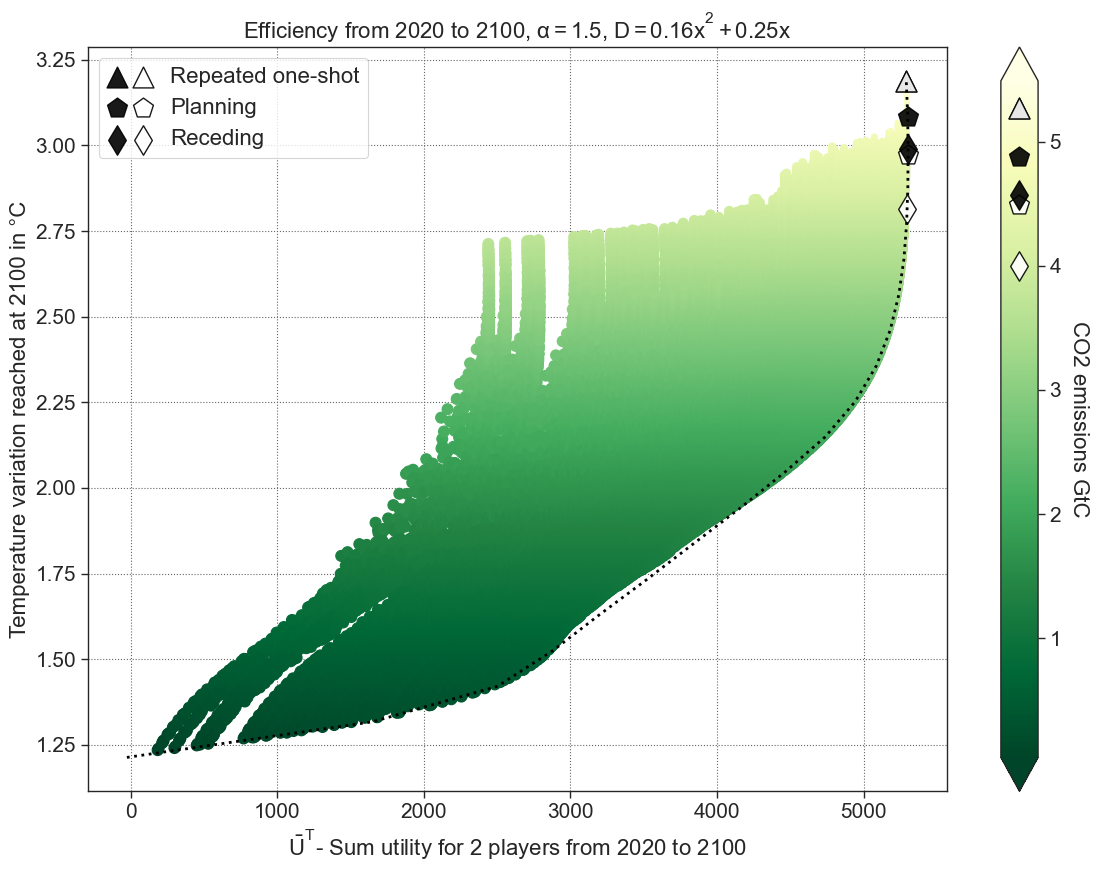

In [27]:
from matplotlib.legend_handler import HandlerTuple

fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
#p = ax.scatter(shuffled_data_u, shuffled_data_t, c=shuffled_data_sum, cmap='coolwarm', marker='.',)
p = ax.scatter(
    data_u_x_low,
    data_t_x_low, 
    c=data_sum_x_low, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x_low ,data_sum_x_low*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)

ax.plot(pareto_low[:,0], pareto_low[:,1], c='black', lw=2 , ls = 'dotted')

p1 = ax.scatter(dict_sum_u_low['NE'], dict_temp_low['NE'], **style_scatter, **one_shot_style, **ne_style, label='Repeated one-shot')
p2 = ax.scatter(dict_sum_u_low['SO'], dict_temp_low['SO'], **style_scatter, **one_shot_style, **so_style)
repeated = (p1, p2)

p1 = ax.scatter(dict_sum_u_low['PLAN_NE'], dict_temp_low['PLAN_NE'], **style_scatter, **planning_style, **ne_style, label='Planning')
p2 = ax.scatter(dict_sum_u_low['PLAN_SO'], dict_temp_low['PLAN_SO'], **style_scatter, **planning_style, **so_style)
planning = (p1,p2)

p1 = ax.scatter(dict_sum_u_low['RECE_NE'], dict_temp_low['RECE_NE'],**style_scatter, **receding_style, **ne_style, label='Receding')
p2 = ax.scatter(dict_sum_u_low['RECE_SO'], dict_temp_low['RECE_SO'],**style_scatter, **receding_style, **so_style)
receding = (p1,p2)

handles, labels = ax.get_legend_handles_labels()
handles = [repeated, planning, receding]
ax.legend(handles = handles, labels = labels, handler_map={tuple: HandlerTuple(ndivide=None)})


cbar = fig.colorbar(p, extend='both')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)
cbar.ax.scatter(x_s,dict_sum_a_low['NE'], **style_scatter, **ne_style, **one_shot_style, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,dict_sum_a_low['SO'], **style_scatter, **so_style, **one_shot_style)
cbar.ax.scatter(x_s,dict_sum_a_low['PLAN_NE'], **style_scatter, **ne_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a_low['PLAN_SO'], **style_scatter, **so_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a_low['RECE_NE'], **style_scatter, **ne_style, **receding_style)
cbar.ax.scatter(x_s,dict_sum_a_low['RECE_SO'], **style_scatter, **so_style, **receding_style)

plt.xlabel(r'$\bar{{U}}^T$- Sum utility for {} players from {} to {}'.format(N, FIRST_YEAR, FINAL_YEAR))
plt.ylabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
plt.title('Efficiency from {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha,low_coef_str))
#plt.title('Efficiency of solution concepts for players\nfrom {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(coef)))
name = 'effciency_low'
filename = f"{case}__alpha_{alpha}__benefit_{case}__damage_{coef_str}".replace('\\', '').replace('{', '').replace('}', '').replace('.', '_').replace('^', '').replace('-', 'moins').replace('+', 'plus')

plt.savefig('journal/'+ name + filename + '.pdf', format='pdf')
plt.show()

# BOTH

In [28]:
from plot_param import *

In [29]:
factor = 7

figsize=((1 + 5**.5)/2 * factor, 1 * factor)
print(figsize)
((1 + 5**.5)/2 * factor, 1 * factor)

(11.326237921249264, 7)


(11.326237921249264, 7)

In [31]:
from utility.transpose_plot import *

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_46824\2633217322.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p, ax=ax,
C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_46824\2633217322.py:98: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p, ax=ax,


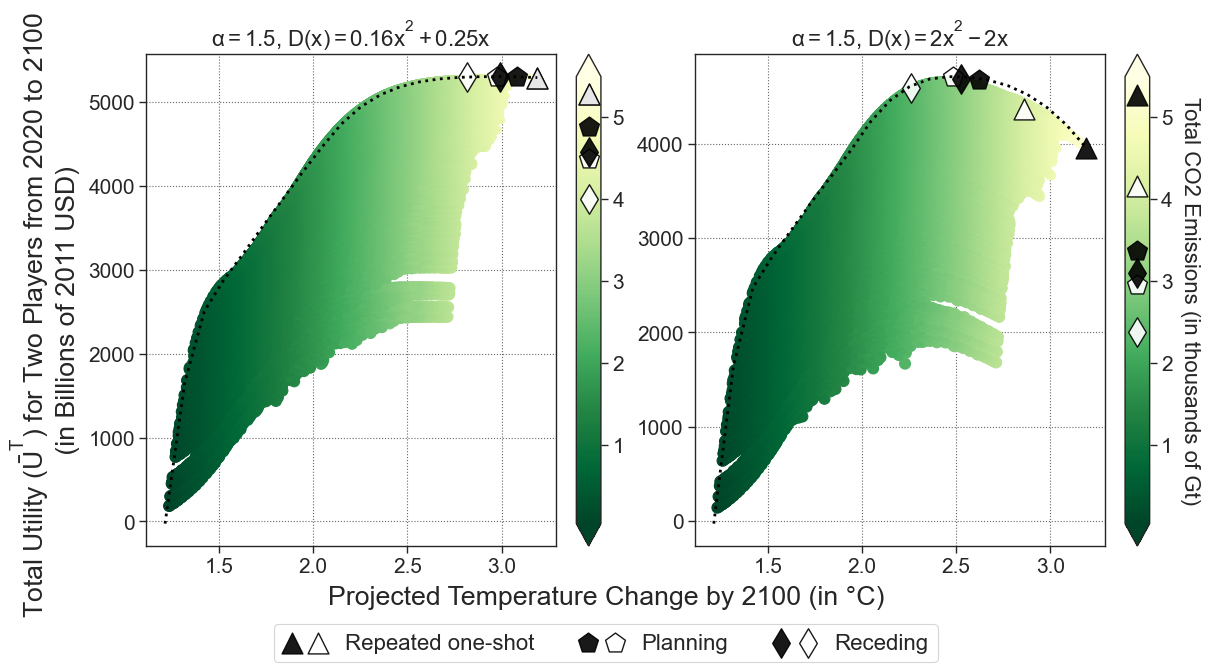

In [33]:
from matplotlib.legend_handler import HandlerTuple
fig, axs = plt.subplots(1, 2, dpi = 100, figsize=(12,6),
                        # sharey=True,
                        layout='constrained')
ax = axs[1]
#p = ax.scatter(shuffled_data_u, shuffled_data_t, c=shuffled_data_sum, cmap='coolwarm', marker='.',)
p = ax.scatter(
    data_u_x,
    data_t_x, 
    c=data_sum_x, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x ,data_sum_x*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)

ax.plot(pareto[:,0], pareto[:,1], c='black', lw=2 , ls = 'dotted')

p1 = ax.scatter(dict_sum_u['NE'], dict_temp['NE'], **style_scatter, **one_shot_style, **ne_style, label='Repeated one-shot')
p2 = ax.scatter(dict_sum_u['SO'], dict_temp['SO'], **style_scatter, **one_shot_style, **so_style)
repeated = (p1, p2)

p1 = ax.scatter(dict_sum_u['PLAN_NE'], dict_temp['PLAN_NE'], **style_scatter, **planning_style, **ne_style, label='Planning')
p2 = ax.scatter(dict_sum_u['PLAN_SO'], dict_temp['PLAN_SO'], **style_scatter, **planning_style, **so_style)
planning = (p1,p2)

p1 = ax.scatter(dict_sum_u['RECE_NE'], dict_temp['RECE_NE'],**style_scatter, **receding_style, **ne_style, label='Receding')
p2 = ax.scatter(dict_sum_u['RECE_SO'], dict_temp['RECE_SO'],**style_scatter, **receding_style, **so_style)
receding = (p1,p2)

handles, labels = ax.get_legend_handles_labels()
handles = [repeated, planning, receding]
# ax.legend(handles = handles, labels = labels, handler_map={tuple: HandlerTuple(ndivide=None)})


cbar = fig.colorbar(p, ax=ax,
                    # location = 'left',
                    extend='both')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
# cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)
cbar.ax.scatter(x_s,dict_sum_a['NE'], **style_scatter, **ne_style, **one_shot_style, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,dict_sum_a['SO'], **style_scatter, **so_style, **one_shot_style)
cbar.ax.scatter(x_s,dict_sum_a['PLAN_NE'], **style_scatter, **ne_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a['PLAN_SO'], **style_scatter, **so_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a['RECE_NE'], **style_scatter, **ne_style, **receding_style)
cbar.ax.scatter(x_s,dict_sum_a['RECE_SO'], **style_scatter, **so_style, **receding_style)
# cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)

ax.set_title('$\\alpha = {}$, $D(x) = {}$'.format(alpha, coef_str))
# ax.yaxis.tick_right()

cbar.set_label('Total CO2 Emissions (in thousands of Gt)', rotation=270, labelpad=20)

transpose_subplot(ax)

ax = axs[0]

p = ax.scatter(
    data_u_x_low,
    data_t_x_low, 
    c=data_sum_x_low, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x_low ,data_sum_x_low*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)

ax.plot(pareto_low[:,0], pareto_low[:,1], c='black', lw=2 , ls = 'dotted')

p1 = ax.scatter(dict_sum_u_low['NE'], dict_temp_low['NE'], **style_scatter, **one_shot_style, **ne_style, label='Repeated one-shot')
p2 = ax.scatter(dict_sum_u_low['SO'], dict_temp_low['SO'], **style_scatter, **one_shot_style, **so_style)
repeated = (p1, p2)

p1 = ax.scatter(dict_sum_u_low['PLAN_NE'], dict_temp_low['PLAN_NE'], **style_scatter, **planning_style, **ne_style, label='Planning')
p2 = ax.scatter(dict_sum_u_low['PLAN_SO'], dict_temp_low['PLAN_SO'], **style_scatter, **planning_style, **so_style)
planning = (p1,p2)

p1 = ax.scatter(dict_sum_u_low['RECE_NE'], dict_temp_low['RECE_NE'],**style_scatter, **receding_style, **ne_style, label='Receding')
p2 = ax.scatter(dict_sum_u_low['RECE_SO'], dict_temp_low['RECE_SO'],**style_scatter, **receding_style, **so_style)
receding = (p1,p2)
ax.set_title('$\\alpha = {}$, $D(x) = {}$'.format(alpha, low_coef_str))

handles, labels = ax.get_legend_handles_labels()
handles = [repeated, planning, receding]


cbar = fig.colorbar(p, ax=ax,
                    # location = 'left',
                    extend='both')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
cbar.ax.scatter(x_s,dict_sum_a_low['NE'], **style_scatter, **ne_style, **one_shot_style, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,dict_sum_a_low['SO'], **style_scatter, **so_style, **one_shot_style)
cbar.ax.scatter(x_s,dict_sum_a_low['PLAN_NE'], **style_scatter, **ne_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a_low['PLAN_SO'], **style_scatter, **so_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a_low['RECE_NE'], **style_scatter, **ne_style, **receding_style)
cbar.ax.scatter(x_s,dict_sum_a_low['RECE_SO'], **style_scatter, **so_style, **receding_style)
# ax.yaxis.tick_right()

ax.yaxis.set_ticks_position('left')
fig.legend(handles = handles, labels = labels, ncol = 3, loc="upper center", bbox_to_anchor=(0.5, 0.00), handler_map={tuple: HandlerTuple(ndivide=None)})
# plt.xlabel(r'$\bar{{U}}^T$- Sum utility for {} players from {} to {}'.format(N, FIRST_YEAR, FINAL_YEAR))
# plt.ylabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
# plt.title('Efficiency from {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(low_coef)))
# #plt.title('Efficiency of solution concepts for players\nfrom {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(coef)))

transpose_subplot(ax)

fig.supylabel('Total Utility ($\\bar{{U}}^T$) for Two Players from {} to {} \n (in Billions of 2011 USD)'.format(FIRST_YEAR, FINAL_YEAR), multialignment='center')
fig.supxlabel('Projected Temperature Change by {} (in °C)'.format(FINAL_YEAR))
# fig.suptitle('Comparison of Strategies Efficiency from {} to {} for Different Damage Functions'.format(FIRST_YEAR, FINAL_YEAR))
name = 'effciency_versus'
filename = f"{case}__alpha_{alpha}__benefit_{case}__damage_{coef_str}".replace('\\', '').replace('{', '').replace('}', '').replace('.', '_').replace('^', '').replace('-', 'moins').replace('+', 'plus')

plt.savefig('journal/'+ name + filename + '.pdf', format='pdf')
plt.show()

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_21468\3107206469.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p, ax=ax,
C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_21468\3107206469.py:97: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p, ax=ax,


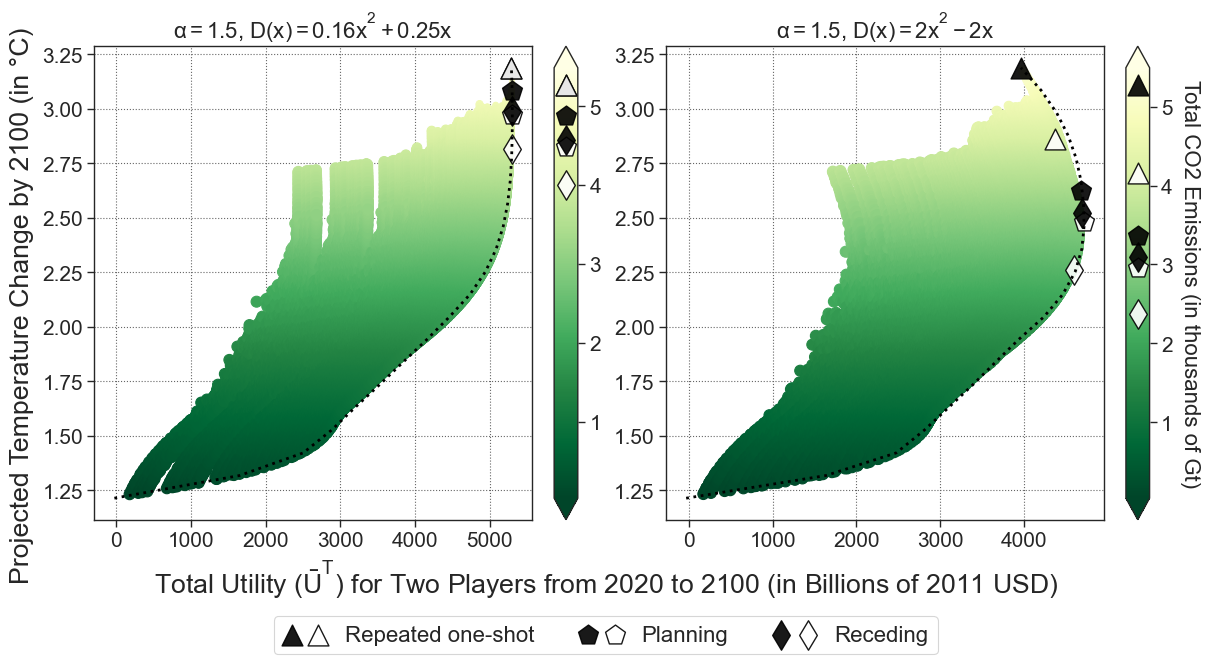

In [ ]:
from matplotlib.legend_handler import HandlerTuple
fig, axs = plt.subplots(1, 2, dpi = 100, figsize=(12,6),
                        # sharey=True,
                        layout='constrained')
ax = axs[1]
#p = ax.scatter(shuffled_data_u, shuffled_data_t, c=shuffled_data_sum, cmap='coolwarm', marker='.',)
p = ax.scatter(
    data_u_x,
    data_t_x, 
    c=data_sum_x, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x ,data_sum_x*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)

ax.plot(pareto[:,0], pareto[:,1], c='black', lw=2 , ls = 'dotted')

p1 = ax.scatter(dict_sum_u['NE'], dict_temp['NE'], **style_scatter, **one_shot_style, **ne_style, label='Repeated one-shot')
p2 = ax.scatter(dict_sum_u['SO'], dict_temp['SO'], **style_scatter, **one_shot_style, **so_style)
repeated = (p1, p2)

p1 = ax.scatter(dict_sum_u['PLAN_NE'], dict_temp['PLAN_NE'], **style_scatter, **planning_style, **ne_style, label='Planning')
p2 = ax.scatter(dict_sum_u['PLAN_SO'], dict_temp['PLAN_SO'], **style_scatter, **planning_style, **so_style)
planning = (p1,p2)

p1 = ax.scatter(dict_sum_u['RECE_NE'], dict_temp['RECE_NE'],**style_scatter, **receding_style, **ne_style, label='Receding')
p2 = ax.scatter(dict_sum_u['RECE_SO'], dict_temp['RECE_SO'],**style_scatter, **receding_style, **so_style)
receding = (p1,p2)

handles, labels = ax.get_legend_handles_labels()
handles = [repeated, planning, receding]
# ax.legend(handles = handles, labels = labels, handler_map={tuple: HandlerTuple(ndivide=None)})


cbar = fig.colorbar(p, ax=ax,
                    # location = 'left',
                    extend='both')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
# cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)
cbar.ax.scatter(x_s,dict_sum_a['NE'], **style_scatter, **ne_style, **one_shot_style, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,dict_sum_a['SO'], **style_scatter, **so_style, **one_shot_style)
cbar.ax.scatter(x_s,dict_sum_a['PLAN_NE'], **style_scatter, **ne_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a['PLAN_SO'], **style_scatter, **so_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a['RECE_NE'], **style_scatter, **ne_style, **receding_style)
cbar.ax.scatter(x_s,dict_sum_a['RECE_SO'], **style_scatter, **so_style, **receding_style)
# cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)

ax.set_title('$\\alpha = {}$, $D(x) = {}$'.format(alpha, coef_str))
# ax.yaxis.tick_right()

cbar.set_label('Total CO2 Emissions (in thousands of Gt)', rotation=270, labelpad=20)


ax = axs[0]

p = ax.scatter(
    data_u_x_low,
    data_t_x_low, 
    c=data_sum_x_low, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x_low ,data_sum_x_low*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)

ax.plot(pareto_low[:,0], pareto_low[:,1], c='black', lw=2 , ls = 'dotted')

p1 = ax.scatter(dict_sum_u_low['NE'], dict_temp_low['NE'], **style_scatter, **one_shot_style, **ne_style, label='Repeated one-shot')
p2 = ax.scatter(dict_sum_u_low['SO'], dict_temp_low['SO'], **style_scatter, **one_shot_style, **so_style)
repeated = (p1, p2)

p1 = ax.scatter(dict_sum_u_low['PLAN_NE'], dict_temp_low['PLAN_NE'], **style_scatter, **planning_style, **ne_style, label='Planning')
p2 = ax.scatter(dict_sum_u_low['PLAN_SO'], dict_temp_low['PLAN_SO'], **style_scatter, **planning_style, **so_style)
planning = (p1,p2)

p1 = ax.scatter(dict_sum_u_low['RECE_NE'], dict_temp_low['RECE_NE'],**style_scatter, **receding_style, **ne_style, label='Receding')
p2 = ax.scatter(dict_sum_u_low['RECE_SO'], dict_temp_low['RECE_SO'],**style_scatter, **receding_style, **so_style)
receding = (p1,p2)
ax.set_title('$\\alpha = {}$, $D(x) = {}$'.format(alpha, low_coef_str))

handles, labels = ax.get_legend_handles_labels()
handles = [repeated, planning, receding]


cbar = fig.colorbar(p, ax=ax,
                    # location = 'left',
                    extend='both')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
cbar.ax.scatter(x_s,dict_sum_a_low['NE'], **style_scatter, **ne_style, **one_shot_style, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,dict_sum_a_low['SO'], **style_scatter, **so_style, **one_shot_style)
cbar.ax.scatter(x_s,dict_sum_a_low['PLAN_NE'], **style_scatter, **ne_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a_low['PLAN_SO'], **style_scatter, **so_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_a_low['RECE_NE'], **style_scatter, **ne_style, **receding_style)
cbar.ax.scatter(x_s,dict_sum_a_low['RECE_SO'], **style_scatter, **so_style, **receding_style)
# ax.yaxis.tick_right()

ax.yaxis.set_ticks_position('left')
fig.legend(handles = handles, labels = labels, ncol = 3, loc="upper center", bbox_to_anchor=(0.5, 0.00), handler_map={tuple: HandlerTuple(ndivide=None)})
# plt.xlabel(r'$\bar{{U}}^T$- Sum utility for {} players from {} to {}'.format(N, FIRST_YEAR, FINAL_YEAR))
# plt.ylabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
# plt.title('Efficiency from {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(low_coef)))
# #plt.title('Efficiency of solution concepts for players\nfrom {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(coef)))

fig.supxlabel(r'Total Utility ($\bar{{U}}^T$) for Two Players from {} to {} (in Billions of 2011 USD)'.format(FIRST_YEAR, FINAL_YEAR))
fig.supylabel('Projected Temperature Change by {} (in °C)'.format(FINAL_YEAR))
# fig.suptitle('Comparison of Strategies Efficiency from {} to {} for Different Damage Functions'.format(FIRST_YEAR, FINAL_YEAR))
name = 'effciency_versus'
filename = f"{case}__alpha_{alpha}__benefit_{case}__damage_{coef_str}".replace('\\', '').replace('{', '').replace('}', '').replace('.', '_').replace('^', '').replace('-', 'moins').replace('+', 'plus')

plt.savefig('journal/'+ name + filename + '.pdf', format='pdf')
plt.show()

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_28788\1753470325.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p, cax=axs[1], extend='both')


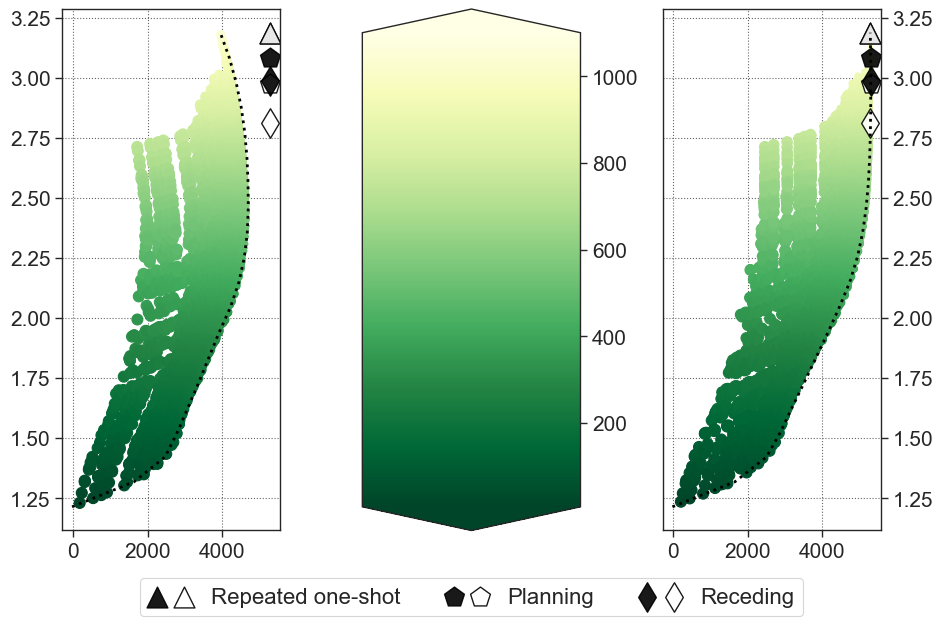

In [137]:
from matplotlib.legend_handler import HandlerTuple

fig, axs = plt.subplots(1, 3, dpi = 100, figsize=figsize)
ax = axs[0]
#p = ax.scatter(shuffled_data_u, shuffled_data_t, c=shuffled_data_sum, cmap='coolwarm', marker='.',)
p = ax.scatter(
    data_u_x,
    data_t_x, 
    c=data_sum_x, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x ,data_sum_x*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)

ax.plot(pareto[:,0], pareto[:,1], c='black', lw=2 , ls = 'dotted')

p1 = ax.scatter(dict_sum_u['NE'], dict_temp['NE'], **style_scatter, **one_shot_style, **ne_style, label='Repeated one-shot')
p2 = ax.scatter(dict_sum_u['SO'], dict_temp['SO'], **style_scatter, **one_shot_style, **so_style)
repeated = (p1, p2)

p1 = ax.scatter(dict_sum_u['PLAN_NE'], dict_temp['PLAN_NE'], **style_scatter, **planning_style, **ne_style, label='Planning')
p2 = ax.scatter(dict_sum_u['PLAN_SO'], dict_temp['PLAN_SO'], **style_scatter, **planning_style, **so_style)
planning = (p1,p2)

p1 = ax.scatter(dict_sum_u['RECE_NE'], dict_temp['RECE_NE'],**style_scatter, **receding_style, **ne_style, label='Receding')
p2 = ax.scatter(dict_sum_u['RECE_SO'], dict_temp['RECE_SO'],**style_scatter, **receding_style, **so_style)
receding = (p1,p2)

handles, labels = ax.get_legend_handles_labels()
handles = [repeated, planning, receding]
# ax.legend(handles = handles, labels = labels, handler_map={tuple: HandlerTuple(ndivide=None)})


cbar = fig.colorbar(p, cax=axs[1], extend='both')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
# cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)
cbar.ax.scatter(x_s,dict_sum_u['NE'], **style_scatter, **ne_style, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,dict_sum_u['SO'], **style_scatter, **so_style)
cbar.ax.scatter(x_s,dict_sum_u['PLAN_NE'], **style_scatter, **ne_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_u['PLAN_SO'], **style_scatter, **so_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_u['RECE_NE'], **style_scatter, **ne_style, **receding_style)
cbar.ax.scatter(x_s,dict_sum_u['RECE_SO'], **style_scatter, **so_style, **receding_style)
# cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)

# ax.set_xlabel(r'$\bar{{U}}^T$- Sum utility for {} players from {} to {}'.format(N, FIRST_YEAR, FINAL_YEAR))
# ax.set_ylabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
# ax.set_title('Efficiency from {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(low_coef)))
# #plt.title('Efficiency of solution concepts for players\nfrom {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(coef)))
# name = 'effciency'
# filename = f"{case}__alpha_{alpha}__benefit_{case}__damage_{coef_str}".replace('\\', '').replace('{', '').replace('}', '').replace('.', '_').replace('^', '').replace('-', 'moins').replace('+', 'plus')

ax = axs[2]

p = ax.scatter(
    data_u_x_low,
    data_t_x_low, 
    c=data_sum_x_low, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x_low ,data_sum_x_low*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)

ax.plot(pareto_low[:,0], pareto_low[:,1], c='black', lw=2 , ls = 'dotted')

p1 = ax.scatter(dict_sum_u_low['NE'], dict_temp_low['NE'], **style_scatter, **one_shot_style, **ne_style, label='Repeated one-shot')
p2 = ax.scatter(dict_sum_u_low['SO'], dict_temp_low['SO'], **style_scatter, **one_shot_style, **so_style)
repeated = (p1, p2)

p1 = ax.scatter(dict_sum_u_low['PLAN_NE'], dict_temp_low['PLAN_NE'], **style_scatter, **planning_style, **ne_style, label='Planning')
p2 = ax.scatter(dict_sum_u_low['PLAN_SO'], dict_temp_low['PLAN_SO'], **style_scatter, **planning_style, **so_style)
planning = (p1,p2)

p1 = ax.scatter(dict_sum_u_low['RECE_NE'], dict_temp_low['RECE_NE'],**style_scatter, **receding_style, **ne_style, label='Receding')
p2 = ax.scatter(dict_sum_u_low['RECE_SO'], dict_temp_low['RECE_SO'],**style_scatter, **receding_style, **so_style)
receding = (p1,p2)

handles, labels = ax.get_legend_handles_labels()
handles = [repeated, planning, receding]


# cbar = fig.colorbar(p, ax=axs[1], location = 'left', extend='both')
x_s = cbar.ax.set_xlim()
x_s = 2*sum(x_s)/3
# cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)
cbar.ax.scatter(x_s,dict_sum_u_low['NE'], **style_scatter, **ne_style, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,dict_sum_u_low['SO'], **style_scatter, **so_style)
cbar.ax.scatter(x_s,dict_sum_u_low['PLAN_NE'], **style_scatter, **ne_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_u_low['PLAN_SO'], **style_scatter, **so_style, **planning_style)
cbar.ax.scatter(x_s,dict_sum_u_low['RECE_NE'], **style_scatter, **ne_style, **receding_style)
cbar.ax.scatter(x_s,dict_sum_u_low['RECE_SO'], **style_scatter, **so_style, **receding_style)
ax.yaxis.tick_right()

fig.legend(handles = handles, labels = labels, ncol = 3, loc="upper center", bbox_to_anchor=(0.5, 0.03), handler_map={tuple: HandlerTuple(ndivide=None)})
# plt.xlabel(r'$\bar{{U}}^T$- Sum utility for {} players from {} to {}'.format(N, FIRST_YEAR, FINAL_YEAR))
# plt.ylabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
# plt.title('Efficiency from {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(low_coef)))
# #plt.title('Efficiency of solution concepts for players\nfrom {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(coef)))
# name = 'effciency_low'
# filename = f"{case}__alpha_{alpha}__benefit_{case}__damage_{coef_str}".replace('\\', '').replace('{', '').replace('}', '').replace('.', '_').replace('^', '').replace('-', 'moins').replace('+', 'plus')

# plt.savefig('journal/'+ name + filename + '.pdf', format='pdf')
plt.show()

In [135]:
x_s, dict_sum_u_low['NE']

(0.5, 5291.823166478382)

# END

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_27932\1076234252.py:76: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p, extend='both')


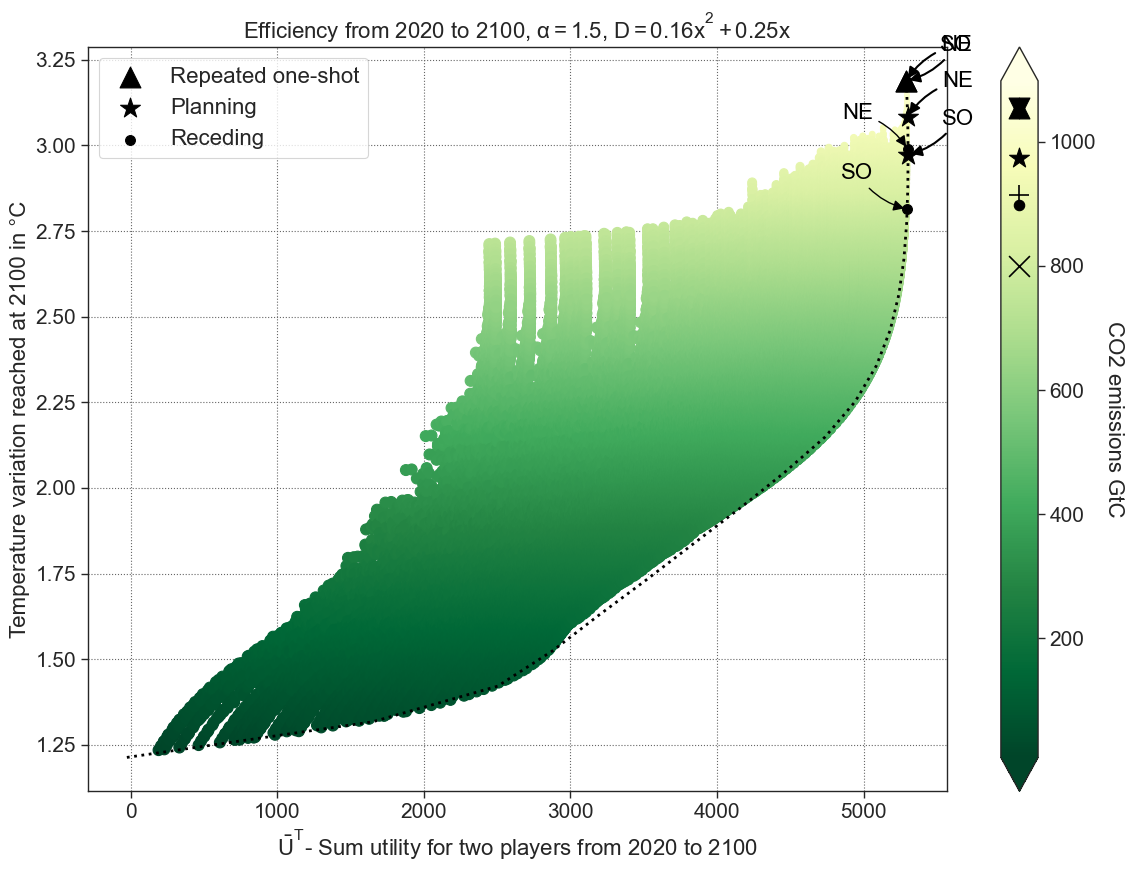

In [27]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
#p = ax.scatter(shuffled_data_u, shuffled_data_t, c=shuffled_data_sum, cmap='coolwarm', marker='.',)
p = ax.scatter(
    data_u_x,
    data_t_x, 
    c=data_sum_x, 
    cmap='YlGn_r',
    rasterized=True,
    marker='.', 
    s=s
    )


all_temp = np.concatenate([data_sum_x,data_sum_x*1.05], axis = 0)
min_, max_ = all_temp.min(), all_temp.max()
p.set_clim(min_, max_)
#p = ax.scatter(data_u_y, data_t_y, c=data_sum_y, cmap='coolwarm', marker='.',)
#p = ax.tricontour(data_u_x, data_t_x, data_sum_x) #, cmap='coolwarm', marker='.', s=75)

# ax[0] =  sns.kdeplot(x=data_u[:,0], y=data_u[:,1], hue=data_t[:,T-1], warn_singular=False)

ax.plot(pareto[:,0], pareto[:,1], c='black', lw=2 , ls = 'dotted')


ax.scatter(np.sum(u__), temp_[T-1], marker='^', c='black', label='Repeated one-shot')
ax.annotate('NE', (np.sum(u__), temp_[T-1]),  c='black',
            textcoords="offset pixels", # how to position the text
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", color='black', lw=1.5),
                xytext=(50.,30) , # distance from text to points (x,y)
                 ha='center'
            )

ax.scatter(np.sum(u_so_), temp_so[T-1], marker='^', c='black')
ax.annotate('SO', (np.sum(u_so_), temp_so[T-1]),  c='black',
            textcoords="offset pixels", # how to position the text
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", color='black', lw=1.5),
                xytext=(50.,30) , # distance from text to points (x,y)
                 ha='center'
            )

ax.scatter(np.sum(u_p), temp_plan[T-1], marker='*', c='black', label='Planning')

ax.annotate('NE', (np.sum(u_p), temp_plan[T-1]),  c='black',
            textcoords="offset pixels", # how to position the text
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", color='black', lw=1.5),
                xytext=(50.,30) , # distance from text to points (x,y)
                 ha='center'
            )
ax.scatter(np.sum(u_p_so),temp_plan_so[T-1], marker='*',c='black')
ax.annotate('SO', (np.sum(u_p_so), temp_plan_so[T-1]),  c='black',
            textcoords="offset pixels", # how to position the text
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", color='black', lw=1.5),
                xytext=(50.,30) , # distance from text to points (x,y)
                 ha='center'
            )


ax.scatter(np.sum(u_r),temp_rece[T-1], marker='o', s=50, c='black', label='Receding')

ax.annotate('NE', (np.sum(u_r), temp_rece[T-1]),  c='black',
            textcoords="offset pixels", # how to position the text
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.2", color='black', lw=1),
                xytext=(-50.,30) , # distance from text to points (x,y)
                 ha='center'
            )

ax.scatter(np.sum(u_r_so),temp_rece_so[T-1], marker='o', s=50, c='black')

ax.annotate('SO', (np.sum(u_r_so), temp_rece_so[T-1]),  c='black',
            textcoords="offset pixels", # how to position the text
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", color='black', lw=1),
                xytext=(-50.,30) , # distance from text to points (x,y)
                 ha='center'
            )
cbar = fig.colorbar(p, extend='both')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
ax.legend(loc='upper left')
cbar.ax.scatter(x_s,np.sum(a_), marker='^',c='black',  label='Repeated one-shot NE')
cbar.ax.scatter(x_s,np.sum(a_so), marker='v',c='black',label='Repeated one-shot SO')

cbar.set_label('CO2 emissions GtC', rotation=270, labelpad=20)
cbar.ax.scatter(x_s,np.sum(a_plan), marker='*', c='black',  label='Nash Equilibria')
cbar.ax.scatter(x_s,np.sum(a_rece), marker='+', c='black', label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,np.sum(a_plan_so), marker='.',c='black',  label='SO')
cbar.ax.scatter(x_s,np.sum(a_rece_so), marker='x',c='black',  label='Receding SO')

plt.xlabel(r'$\bar{{U}}^T$- Sum utility for two players from {} to {}'.format(FIRST_YEAR, FINAL_YEAR))
plt.ylabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
plt.title('Efficiency from {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(coef)))
#plt.title('Efficiency of solution concepts for players\nfrom {} to {}, $\\alpha = {}$, $D = {}$'.format(FIRST_YEAR, FINAL_YEAR, alpha, array_to_latex(coef)))
# plt.savefig('journal/'+ title + '.pdf', format='pdf')
plt.show()

In [ ]:
N = 3
"Default number of players"

# Espaces d'action des joueurs en GtCO2


ACTION_SETS =  np.array([[[0.0, 11.47],        # China  
                         [0.0, 5.01],
                         [0.0, 5.01]]]*2*T)*4       # other 

ACTION_SETS = np.swapaxes(ACTION_SETS,0,1)


r"""Default action set of the players.

References
----------

.. [1] Hannah Ritchie, Max Roser and Pablo Rosado (2020) - "CO₂ and Greenhouse Gas Emissions". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions' [Online Resource]
       https://ourworldindata.org/grapher/annual-co2-emissions-per-country?facet=none&country=CHN~USA~European+Union+%2828%29~IND~RUS~Asia+%28excl.+China+and+India%29

"""

# ACTION_SETS =  np.array([[[0.0, 10.0],        # China  
#                          [0.0, 0.1],         # USA
#                          [0.0, 0.1],         # EU
#                          [0.0, 0.1],         # India
#                          [0.0, 0.1],         # Russia
#                          [0.0, 0.1]]]*T)  
# Coefficient d'impact de la temperature sur le climat 

DELTAS = np.array([1.1847,
                    1.1941,
                    1.2941])
r"""Default damage multiplier. 

References
----------

.. [1] http://www.fund-model.org/MimiFUND.jl/latest/tables/#Table-RT:-Regional-temperature-conversion-factor-1
"""



# PIB max des joueurs, j'ai pris le PIB 2020                

GDP_MAX = np.array([14.63,
                    19.29,
                    15.29])*10


NAMES = ['China', 'USA', 'OW']


r = [ 0.2, 0.4, 0.3]
e = [10,-2, 2]